In [1]:
!ls /kaggle/input/tsai-model-explanability-v1

TestImages  model.scripted.pt


In [2]:
!pip install --quiet timm captum shap grad-cam opencv-python


# Imports

In [3]:
## Importing Libraries
import os
import sys

import shap
import timm
import torch
import urllib
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import os

from PIL import Image
from captum.robust import PGD, FGSM
from captum.attr import FeatureAblation
from matplotlib.colors import LinearSegmentedColormap
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

from captum.attr import (
    DeepLift,
    Saliency,
    Occlusion,
    NoiseTunnel,
    GradientShap,
    IntegratedGradients,
    visualization as viz,
)
import cv2


In [4]:
# device initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Download human-readable labels for ImageNet.
# get the classnames
# url, filename = (
#     "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
#     "imagenet_classes.txt",
# )
# urllib.request.urlretrieve(url, filename)
# with open("imagenet_classes.txt", "r") as f:
#     categories = [s.strip() for s in f.readlines()]
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
idx_to_class = {0:"buildings",1: 'forest', 2: 'glacier', 3:'mountain' , 4:'sea' , 5:'street'}

In [6]:
!ls /kaggle/input/tsai-model-explanability-v1/TestImages/

building.jpg  forest.jpg  glacier.jpg  mountain.jpg  sea.jpg  street.jpg


In [7]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"


def model_fn(model_dir):
    model = torch.jit.load(f"{model_dir}/model.scripted.pt")

    model.to(device).eval()
    
    return model

model_dir = "/kaggle/input/tsai-model-explanability-v1"
model = model_fn(model_dir)
model.eval()
model = model.to(device)


In [8]:
model

RecursiveScriptModule(
  original_name=LitResnet
  (model): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (act1): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (drop_block): RecursiveScriptModule(original_name=Identity)
        (act1): RecursiveScriptModule(original_name=ReLU)
        (aa): RecursiveScriptModule(original_name=Identity)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (act2): RecursiveScriptModule(original_name=ReLU)
      )
      (1): RecursiveSc

In [32]:
model.named_modules()
[name for name, module in model.named_modules()]
model.model.layer4

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(
    original_name=BasicBlock
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (drop_block): RecursiveScriptModule(original_name=Identity)
    (act1): RecursiveScriptModule(original_name=ReLU)
    (aa): RecursiveScriptModule(original_name=Identity)
    (conv2): RecursiveScriptModule(original_name=Conv2d)
    (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    (act2): RecursiveScriptModule(original_name=ReLU)
    (downsample): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
    )
  )
  (1): RecursiveScriptModule(
    original_name=BasicBlock
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (drop_block): RecursiveScriptModule(original_name=Id

In [9]:
import torchvision.transforms as T
import torch.nn.functional as F
import json
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = T.Compose([T.ToPILImage(),
                        T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [10]:
# inference
def predict_fn(input_object, model):
    with torch.no_grad():
        prediction = model(input_object)
        prediction = F.softmax(prediction, dim=1)
    
    confidences, cat_ids = torch.topk(prediction, 5)
    outputs = {
        idx_to_class[idx.item()]: c.item() for c, idx in zip(confidences[0], cat_ids[0])
    }
    return outputs



In [11]:
from PIL import Image
  
# open method used to open different extension image file
data = Image.open(r"/kaggle/input/tsai-model-explanability-v1/TestImages/building.jpg")
data = transform(np.array(data).astype(np.uint8)).unsqueeze(0).to(device)

predict_fn(data, model)

{'buildings': 0.9281207919120789,
 'sea': 0.033476270735263824,
 'street': 0.017135798931121826,
 'mountain': 0.00863709207624197,
 'glacier': 0.007338303606957197}

In [12]:
# inference
def predict_fn2(input_object, model):
    transform = T.Compose([T.ToPILImage(),
                        T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    input_object = transform(np.array(input_object).astype(np.uint8)).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(input_object)
        prediction = F.softmax(prediction, dim=1)
    
    confidences, cat_ids = torch.topk(prediction, 1)
    
    return cat_ids
data = Image.open(r"/kaggle/input/tsai-model-explanability-v1/TestImages/building.jpg")

predict_fn2(data, model).item()

0

In [13]:
import os
image_list = os.listdir("/kaggle/input/tsai-model-explanability-v1/TestImages")

print("image_list: ", image_list)

image_list:  ['mountain.jpg', 'street.jpg', 'glacier.jpg', 'building.jpg', 'sea.jpg', 'forest.jpg']


In [14]:
# output folder
if not os.path.exists("output/"):
    os.makedirs("output/")

In [15]:
!ls output/

In [16]:
# model = timm.create_model("vit_base_patch32_224", pretrained=True)
# model.eval()
# model = model.to(device)
# model = timm.create_model("resnet18", pretrained=True)
# model.eval()
# model = model.to(device)


In [17]:
# only for noiseTunnel that works on resnet18, gives memory error with vit


def integratedGradients(img_tensor, transformed_img, path_dir, model, pred_label_idx):
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(
        img_tensor, target=pred_label_idx, n_steps=50
    )

    default_cmap = LinearSegmentedColormap.from_list(
        "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
    )

    sth = viz.visualize_image_attr_multiple(
        np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "absolute_value"],
        cmap=default_cmap,
        show_colorbar=True,
#         sign="positive",
        outlier_perc=1,
        use_pyplot=False,
    )

    sth[0].savefig(path_dir + "_ig.png")
    return integrated_gradients

def noiseTunnel(img_tensor, transformed_img, path_dir, pred_label_idx, integrated_gradients):
    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_ig_nt = noise_tunnel.attribute(
        img_tensor, nt_samples=10, nt_type="smoothgrad_sq", target=pred_label_idx
    )

    default_cmap = LinearSegmentedColormap.from_list(
        "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
    )

    sth = viz.visualize_image_attr_multiple(
        np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "positive"],
        cmap=default_cmap,
        show_colorbar=True,
        use_pyplot=False,
    )
    sth[0].savefig(path_dir + "_ig_with_noisetunnel.png")
    
for i, image in enumerate(image_list):
    # create the directory for each image
    temp_dir = f"output/_{i}/"
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    op_image_name = temp_dir + "_" + image
    print("Processing image: ", image)

    transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])

    transform_normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    img_path = "/kaggle/input/tsai-model-explanability-v1/TestImages/" + image
    img = Image.open(img_path)


    transformed_img = transform(img)

    img_tensor = transform_normalize(transformed_img)
    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)
    output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]
    # print("Predicted:", predicted_label, "(", prediction_score.squeeze().item(), ")")

    # integrated gradients
    integrated_gradients = integratedGradients(img_tensor, transformed_img, op_image_name, model, pred_label_idx)
 
    # noise Tunnel
    noiseTunnel(img_tensor, transformed_img, op_image_name, pred_label_idx, integrated_gradients)




Processing image:  mountain.jpg
Processing image:  street.jpg
Processing image:  glacier.jpg
Processing image:  building.jpg
Processing image:  sea.jpg
Processing image:  forest.jpg


In [33]:

def grad_cam_visualization(img_path, path_dir):
#     model = torch.hub.load('facebookresearch/deit:main',
#                            'deit_tiny_patch16_224', pretrained=True)
#     model.eval()
#     model.cuda()
    # Grad CAM
    

#     target_layers = [model.blocks[-1].norm1]

   
    def reshape_transform(tensor, height=14, width=14):
        result = tensor[:, 1:, :].reshape(tensor.size(0),
                                          height, width, tensor.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        result = result.transpose(2, 3).transpose(1, 2)
#         print(result.shape)
        return result
    
    rgb_img = cv2.imread(img_path, 1)#[:, :, ::-1]
#     print(rgb_img.shape)
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    img_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
#     print(img_tensor.shape)
    targets = None

    target_layers = [model.model.layer4]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    targets = [ClassifierOutputTarget(281)]
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets, eigen_smooth=True, aug_smooth=True)

    # In this example grayscale_cam has only one image in the batch:
    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    cv2.imwrite(path_dir + "_gradcam.png", cam_image)

#     plt.imshow(visualization)


    cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    cv2.imwrite(path_dir + "_gradcam_plus_plus.png", cam_image)


In [34]:

def integratedGradients(img_tensor, transformed_img, path_dir, model, pred_label_idx):
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(
        img_tensor, target=pred_label_idx, n_steps=50
    )

    default_cmap = LinearSegmentedColormap.from_list(
        "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
    )

    sth = viz.visualize_image_attr_multiple(
        np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "absolute_value"],
        cmap=default_cmap,
        show_colorbar=True,
#         sign="positive",
        outlier_perc=1,
        use_pyplot=False,
    )

    sth[0].savefig(path_dir + "_ig.png")
    return integrated_gradients


def noiseTunnel(img_tensor, transformed_img, path_dir, pred_label_idx, integrated_gradients):
    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_ig_nt = noise_tunnel.attribute(
        img_tensor, nt_samples=10, nt_type="smoothgrad_sq", target=pred_label_idx
    )

    default_cmap = LinearSegmentedColormap.from_list(
        "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
    )

    sth = viz.visualize_image_attr_multiple(
        np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "positive"],
        cmap=default_cmap,
        show_colorbar=True,
        use_pyplot=False,
    )
    sth[0].savefig(path_dir + "_ig_with_noisetunnel.png")


def gradientShap(img_tensor, transformed_img, path_dir, model, pred_label_idx):
    gradient_shap = GradientShap(model)

    # Defining baseline distribution of images
    rand_img_dist = torch.cat([img_tensor * 0, img_tensor * 1])

    default_cmap = LinearSegmentedColormap.from_list(
        "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
    )

    attributions_gs = gradient_shap.attribute(
        img_tensor,
        n_samples=50,
        stdevs=0.0001,
        baselines=rand_img_dist,
        target=pred_label_idx,
    )
    sth = viz.visualize_image_attr_multiple(
        np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "absolute_value"],
        cmap=default_cmap,
        show_colorbar=True,
        use_pyplot=False,
    )

    sth[0].savefig(path_dir + "_gradient_shap.png")


def occlusion_output(img_tensor, transformed_img, path_dir, model, pred_label_idx):
    occlusion = Occlusion(model)

    attributions_occ = occlusion.attribute(
        img_tensor,
        strides=(3, 8, 8),
        target=pred_label_idx,
        sliding_window_shapes=(3, 15, 15),
        baselines=0,
    )

    sth = viz.visualize_image_attr_multiple(
        np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        ["original_image", "heat_map"],
        ["all", "positive"],
        show_colorbar=True,
        outlier_perc=2,
        use_pyplot=False,
    )

    sth[0].savefig(path_dir + "_occlusion.png")


def shap_output(img, path_dir, model):

    # ## SHAP

    # Works well where number of classes are less

    transform = T.Compose(
        [
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)

    model_out = model(img_tensor)
    classes = torch.argmax(model_out, axis=1).cpu().numpy()
    # print(f"Classes: {classes}: {np.array(categories)[classes]}")


    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inv_transform = T.Compose(
        [
            T.Lambda(lambda x: x.permute(0, 3, 1, 2)),
            T.Normalize(
                mean=(-1 * np.array(mean) / np.array(std)).tolist(),
                std=(1 / np.array(std)).tolist(),
            ),
            T.Lambda(lambda x: x.permute(0, 2, 3, 1)),
        ]
    )

    def predict(imgs: torch.Tensor) -> torch.Tensor:
        imgs = torch.tensor(imgs)
        imgs = imgs.permute(0, 3, 1, 2)

        img_tensor = imgs.to(device)

        output = model(img_tensor)
        return output

    topk = 4
    batch_size = 50
    n_evals = 10000

    # define a masker that is used to mask out partitions of the input image.
    masker_blur = shap.maskers.Image("blur(128,128)", (224, 224, 3))

    # create an explainer with model and image masker
    explainer = shap.Explainer(predict, masker_blur, output_names=categories)

    # feed only one image
    # here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
    # image_np = Image.open("cat.jpeg")
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.permute(0, 2, 3, 1)

    shap_values = explainer(
        img_tensor,
        max_evals=n_evals,
        batch_size=batch_size,
        outputs=shap.Explanation.argsort.flip[:topk],
    )

    # (shap_values.data.shape, shap_values.values.shape)

    shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]

    shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]
    
    # get one top prediction
    pred_label = int(predict_fn2(img, model).item())
    shap.image_plot(
        shap_values=shap_values.values,
        pixel_values=shap_values.data,
        labels=shap_values.output_names,
        true_labels=[categories[pred_label]],
        show=False
    )

    # plt.show(block=False)

    plt.savefig(path_dir+ '_shap.png')

    
def saliency_output(img, model, path_dir ):
    transform = T.Compose(
        [
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor.requires_grad = True
    img_tensor = img_tensor.to(device)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inv_transform = T.Compose(
        [
            T.Normalize(
                mean=(-1 * np.array(mean) / np.array(std)).tolist(),
                std=(1 / np.array(std)).tolist(),
            ),
        ]
    )
    # get one top prediction
    pred_label = int(predict_fn2(img, model).item())
    saliency = Saliency(model)
    grads = saliency.attribute(img_tensor, target=pred_label)
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

    original_image = np.transpose(
        (img_tensor.squeeze(0).cpu().detach().numpy() / 2) + 0.5, (1, 2, 0)
    )

    sth = viz.visualize_image_attr(
        grads,
        original_image,
        method="blended_heat_map",
        sign="absolute_value",
        show_colorbar=True,
        title="Overlayed Gradient Magnitudes",
        use_pyplot=False,
    )
    sth[0].savefig(path_dir + "_saliency1.png")

    def attribute_image_features(algorithm, input, **kwargs):
        model.zero_grad()
        tensor_attributions = algorithm.attribute(input, target=pred_label, **kwargs)

        return tensor_attributions


    ig = IntegratedGradients(model)
    attr_ig, delta = attribute_image_features(
        ig, img_tensor, baselines=img_tensor * 0, return_convergence_delta=True
    )
    attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    # print("Approximation delta: ", abs(delta))

    sth = viz.visualize_image_attr(
        attr_ig,
        original_image,
        method="blended_heat_map",
        sign="all",
        show_colorbar=True,
        title="Overlayed Integrated Gradients",
        use_pyplot=False,
    )

    sth[0].savefig(path_dir + "_saliency2.png")


def captum_model_robustness(img, model, path_dir):
    transform = T.Compose(
        [
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor.requires_grad = True
    img_tensor = img_tensor.to(device)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inv_transform = T.Compose(
        [
            T.Normalize(
                mean=(-1 * np.array(mean) / np.array(std)).tolist(),
                std=(1 / np.array(std)).tolist(),
            ),
        ]
    )

    def get_prediction(model, image: torch.Tensor):
        model = model.to(device)
#         img_tensor = image.to(device)

        with torch.no_grad():
            output = model(img_tensor)
        output = F.softmax(output, dim=1)
        prediction_score, pred_label_idx = torch.topk(output, 1)

        pred_label_idx.squeeze_()
        predicted_label = categories[pred_label_idx.item()]

        return predicted_label, prediction_score.squeeze().item()

        # print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

    # Get original prediction
    pred, score = get_prediction(model, img_tensor)

    def image_show(img, pred, img_name):
        npimg = inv_transform(img).squeeze().permute(1, 2, 0).detach().numpy()
        plt.imshow(npimg)
        plt.title("prediction: %s" % pred)
        plt.savefig(img_name)

    image_show(img_tensor.cpu(), pred + " " +str(score), path_dir+"_org_img.png")

    # Construct FGSM attacker
    # get one top prediction
    pred_label = int(predict_fn2(img, model).item())
    fgsm = FGSM(model, lower_bound=-1, upper_bound=1)
    perturbed_image_fgsm = fgsm.perturb(img_tensor, epsilon=0.16, target=pred_label)
    new_pred_fgsm, score_fgsm = get_prediction(model, perturbed_image_fgsm)

    # inv_transform(img_tensor).shape

    image_show(perturbed_image_fgsm.cpu(), new_pred_fgsm + " " + str(score_fgsm), path_dir+"_perturbed_image.png")

    pgd = PGD(
        model,
        torch.nn.CrossEntropyLoss(reduction="none"),
        lower_bound=-1,
        upper_bound=1,
    )  # construct the PGD attacker

    perturbed_image_pgd = pgd.perturb(
        inputs=img_tensor,
        radius=0.13,
        step_size=0.02,
        step_num=7,
        target=torch.tensor([pred_label]).to(device),
        targeted=True,
    )
    new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)

    image_show(perturbed_image_pgd.cpu(), new_pred_pgd + " " + str(score_pgd), path_dir+"perturbed_pgd.png")

    

Processing image:  mountain.jpg


  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer: 2it [00:37, 37.06s/it]               
Input Tensor 0 did not already require gradients, required_grads has been set automatically.


RuntimeError: register_forward_hook is not supported on ScriptModules

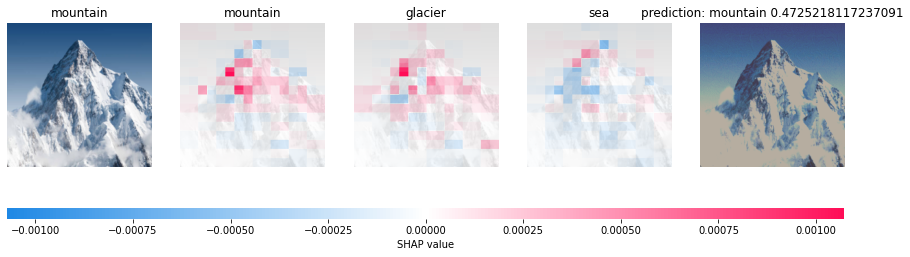

In [35]:
for i, image in enumerate(image_list):
    # create the directory for each image
    temp_dir = f"output/_{i}/"
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    op_image_name = temp_dir + "_" + image
    print("Processing image: ", image)

    transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])

    transform_normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    img_path = "/kaggle/input/tsai-model-explanability-v1/TestImages/" + image
    img = Image.open(img_path)


    transformed_img = transform(img)

    img_tensor = transform_normalize(transformed_img)
    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)
    output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]
    # print("Predicted:", predicted_label, "(", prediction_score.squeeze().item(), ")")

    # integrated gradients
    integrated_gradients = integratedGradients(img_tensor, transformed_img, op_image_name, model, pred_label_idx)
    # noise Tunnel
    noiseTunnel(img_tensor, transformed_img, op_image_name, pred_label_idx, integrated_gradients)

    ##############################################
    torch.manual_seed(0)
    np.random.seed(0)

    gradientShap(img_tensor, transformed_img, op_image_name, model, pred_label_idx)

    occlusion_output(img_tensor, transformed_img, op_image_name, model, pred_label_idx)

    #############################

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inv_transform = T.Compose(
        [
            T.Lambda(lambda x: x.permute(0, 3, 1, 2)),
            T.Normalize(
                mean=(-1 * np.array(mean) / np.array(std)).tolist(),
                std=(1 / np.array(std)).tolist(),
            ),
            T.Lambda(lambda x: x.permute(0, 2, 3, 1)),
        ]
    )

    # ## SHAP

    # Works well where number of classes are less
    shap_output(img, op_image_name, model)


    # model_out = model(img_tensor)
    # classes = torch.argmax(model_out, axis=1).cpu().numpy()
    # print(f"Classes: {classes}: {np.array(categories)[classes]}")

    # Saliency
    saliency_output(img, model, op_image_name)



    # # ## Captum Model Robustness

    captum_model_robustness(img, model, op_image_name)

    # Grad CAM
    grad_cam_visualization(img_path, op_image_name)


In [ ]:
!zip -r output.zip output